In [1]:
import logging
from logging import debug

logging.basicConfig(filename='debug_logs.log',
                    level=logging.DEBUG,
                    # level=logging.ERROR,
                    filemode='w',
                    # format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    # datefmt='%H:%M:%S',
                    )

datalog = logging.getLogger('data_log',)
modellog = logging.getLogger('model_log',)
# datalog.setLevel(logging.DEBUG)

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [2]:
# One pass
%matplotlib inline
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm.notebook import tqdm, trange
import random

from PIL import Image

# For repeatability
seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
debug('#'*32)
debug('RUN')
debug('#'*32)

cuda:0


In [3]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'
                 ):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        self.d_output = num_lvl * grid_dim

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861, 9322189897]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) *0.001 #* 0.0001 #+ torch.rand(1).to(self.device)
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        if x.shape[-1] == 4:
            # Normalization
            _min = torch.tensor([-3.5552, -2.1935, -2.8307, 0]).to(self.device)
            _max = torch.tensor([1.8859, 3.1777, 2.0705, 1]).to(self.device)
            x = (x - _min ) / (_max - _min)
            datalog.debug(f'X in HASH GRID distribution {x.min(), x.max()}')

        # print(x.min(0)[0], x.max(0)[0])
        
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            # Find the floor corner for interpolation
            floor_corner = torch.floor(coord)  
            debug('Floor Corners shape: '+str(floor_corner.shape))

            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            debug('Corners shape: '+str(corners.shape))

            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            debug('Feature_index / flat shape: '+str(feature_index.shape)+' / '+str(flat_feature_index.shape))

            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(
                self.hashtable[lvl][flat_feature_index],
                (corners.shape[0], corners.shape[1], self.feature_dim))
            debug('Corner_feature shape: '+str(corner_feature.shape))

            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            debug('WEIGHTS Before stack shape: '+str(weights.shape))
            
            # Stack weights for each feature
            if self.grid_dim == 2:
                weights = torch.stack([weights, weights], -1)  
            elif self.grid_dim == 3:
                weights = torch.stack([weights, weights, weights], -1)  
            elif self.grid_dim == 4:
                weights = torch.stack([weights, weights, weights, weights], -1)  
            debug('WEIGHTS After stack: '+str(weights.shape))

            # Perform weighted interpolation of corner features
            debug('Corner_feature shape: '+str(corner_feature.shape))
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        outs = torch.cat(out_feature, -1)  # Concatenate features from all levels
        # debug('Hash (max:min) check: '+str(outs.max().item())+' : '+str(outs.min().item()))
        return outs

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        elif self.grid_dim == 3:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                x * minus_y * minus_z,
                                minus_x * y * minus_z,
                                x * y * minus_z,
                                minus_x * minus_y * z,
                                x * minus_y * z,
                                minus_x * y * z,
                                x * y * z], -1)
            return stacks
        elif self.grid_dim == 4:
            # For 4D, calculate weights for the sixteen corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            minus_w = (ones - diff)[..., 3]  # Calculate 1 - w for each dimension
            w = diff[..., 3]  # Get the w difference
            stacks = torch.stack([minus_x * minus_y * minus_z * minus_w,
                                x * minus_y * minus_z * minus_w,
                                minus_x * y * minus_z * minus_w,
                                x * y * minus_z * minus_w,
                                minus_x * minus_y * z * minus_w,
                                x * minus_y * z * minus_w,
                                minus_x * y * z * minus_w,
                                x * y * z * minus_w,
                                minus_x * minus_y * minus_z * w,
                                x * minus_y * minus_z * w,
                                minus_x * y * minus_z * w,
                                x * y * minus_z * w,
                                minus_x * minus_y * z * w,
                                x * minus_y * z * w,
                                minus_x * y * z * w,
                                x * y * z * w], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            debug('Last corner points shape in weights: '+str(c011.shape))
            stacks = torch.stack([c000, c010, c001, c011], -2)
            debug('Stacks shape: '+str(stacks.shape))
            return stacks
        elif self.grid_dim == 3:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            debug('Last corner points shape in weights: '+str(c111.shape))
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            debug('Stacks shape: '+str(stacks.shape))
            return stacks
        elif self.grid_dim == 4:
            # Calculate corners for 4D grids
            c0000 = floor_corner
            c0001 = floor_corner + torch.tensor([0, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c0010 = floor_corner + torch.tensor([0, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c0011 = floor_corner + torch.tensor([0, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c0100 = floor_corner + torch.tensor([0, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c0101 = floor_corner + torch.tensor([0, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c0110 = floor_corner + torch.tensor([0, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c0111 = floor_corner + torch.tensor([0, 1, 1, 1], device=self.device).repeat(num_entry, 1)
            c1000 = floor_corner + torch.tensor([1, 0, 0, 0], device=self.device).repeat(num_entry, 1)
            c1001 = floor_corner + torch.tensor([1, 0, 0, 1], device=self.device).repeat(num_entry, 1)
            c1010 = floor_corner + torch.tensor([1, 0, 1, 0], device=self.device).repeat(num_entry, 1)
            c1011 = floor_corner + torch.tensor([1, 0, 1, 1], device=self.device).repeat(num_entry, 1)
            c1100 = floor_corner + torch.tensor([1, 1, 0, 0], device=self.device).repeat(num_entry, 1)
            c1101 = floor_corner + torch.tensor([1, 1, 0, 1], device=self.device).repeat(num_entry, 1)
            c1110 = floor_corner + torch.tensor([1, 1, 1, 0], device=self.device).repeat(num_entry, 1)
            c1111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            debug('Last corner points shape in weights: '+str(c1111.shape))
            stacks = torch.stack([
                c0000, c0001, c0010, c0011, c0100, c0101, c0110, c0111, 
                c1000, c1001, c1010, c1011, c1100, c1101, c1110, c1111], -2)
            debug('Stacks shape: '+str(stacks.shape))
            return stacks


tensor([[0.0000, 0.0167],
        [0.0333, 0.0500],
        [0.0667, 0.0833],
        [0.1000, 0.1167],
        [0.1333, 0.1500]])
torch.Size([30, 4])


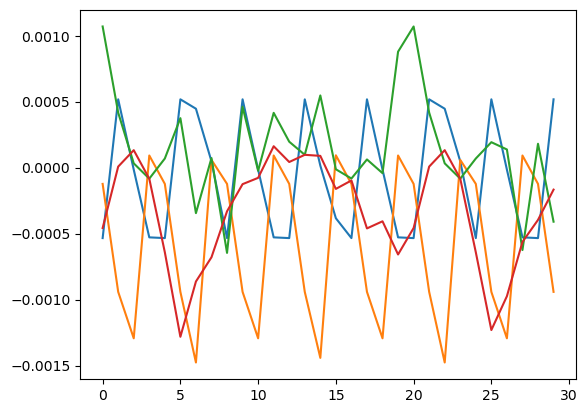

In [4]:
# 2D test
debug('2D TEST'+' -'*12)
torch.manual_seed(2024)
grid_2d = Grid(
    feature_dim=2,
    grid_dim=2,
    num_lvl=2,
    max_res=128,
    min_res=16,
    hashtable_power=4,
    device='cpu'
)
N = 60
x = (torch.arange(N) / N).reshape(-1,2)
print(x[:5])

out = grid_2d(x)
print(out.shape)
plt.plot(out.detach()); plt.show()

torch.Size([20, 3])
tensor([[0.0000, 0.0167, 0.0333],
        [0.0500, 0.0667, 0.0833],
        [0.1000, 0.1167, 0.1333],
        [0.1500, 0.1667, 0.1833],
        [0.2000, 0.2167, 0.2333]])
torch.Size([20, 6])


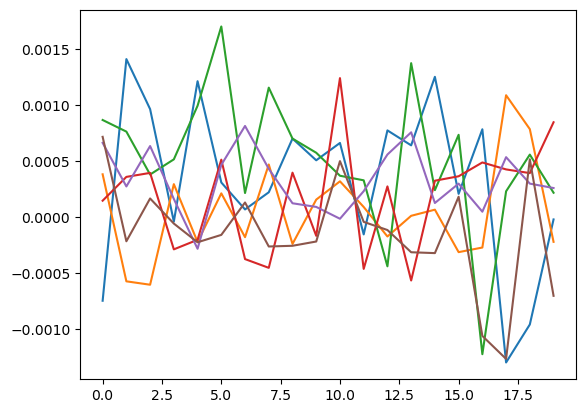

In [5]:
# 3D test
debug('3D TEST'+' -'*12)
torch.manual_seed(2024)
grid_2d = Grid(
    feature_dim=3,
    grid_dim=3,
    num_lvl=2,
    max_res=128,
    min_res=16,
    hashtable_power=4,
    device='cpu'
)
N = 60
x = (torch.arange(N) / N).reshape(-1,3)
print(x.shape)
print(x[:5])

out = grid_2d(x)
print(out.shape)
# print(out[:5])
plt.plot(out.detach()); plt.show()

torch.Size([15, 4])
tensor([[0.0000, 0.0167, 0.0333, 0.0500],
        [0.0667, 0.0833, 0.1000, 0.1167],
        [0.1333, 0.1500, 0.1667, 0.1833],
        [0.2000, 0.2167, 0.2333, 0.2500],
        [0.2667, 0.2833, 0.3000, 0.3167]])
torch.Size([15, 8])


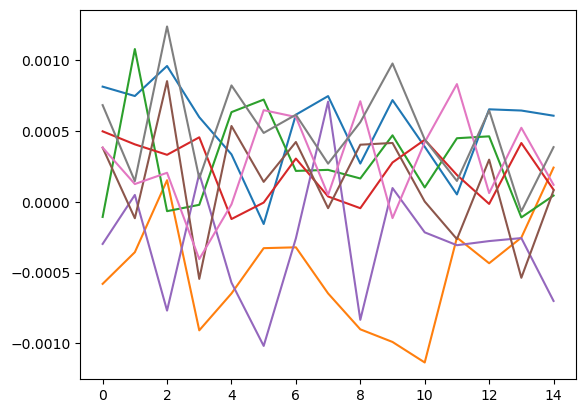

In [6]:
# 4D test
debug('4D TEST'+' -'*12)
torch.manual_seed(2024)
grid_2d = Grid(
    feature_dim=4,
    grid_dim=4,
    num_lvl=2,
    max_res=128,
    min_res=16,
    hashtable_power=4,
    device='cpu'
)
N = 60
x = (torch.arange(N) / N).reshape(-1,4)
print(x.shape)
print(x[:5])

out = grid_2d(x)
print(out.shape)
# print(out[:5])
plt.plot(out.detach()); plt.show()

In [7]:
debug('GRID DEBUG FINISHED!')
debug('#'*32)
# raise SystemExit("Stop right there!")
def _exit():
    raise SystemExit("Stop right there!")


tensor([0.0202])
tensor([0.4040])


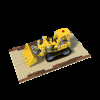

In [8]:
# Load data
data = np.load('../data/tiny_dnerf_data.npz')

n_training = 79
testimg_idx = 1
testimg_idx2 = 20

images = torch.from_numpy(data['images'][:n_training,:,:,:3])
poses = torch.from_numpy(data['poses'][:n_training])
focal = torch.from_numpy(data['focal'])
times = torch.from_numpy(data['times'][:n_training])

# Test
testimg = torch.from_numpy(data['images'][testimg_idx,:,:,:3])
testpose = torch.from_numpy(data['poses'][testimg_idx])
testtime = torch.tensor([data['times'][testimg_idx]])
print(testtime)

testimg2 = torch.from_numpy(data['images'][testimg_idx2,:,:,:3])
testpose2 = torch.from_numpy(data['poses'][testimg_idx2])
testtime2 = torch.tensor([data['times'][testimg_idx2]])
print(testtime2)

height, width = images.shape[1:3]
near, far = 2., 6.

_img = Image.fromarray((testimg*255).numpy().astype(np.uint8))
# _img = Image.fromarray((testimg2*255).numpy().astype(np.uint8))
# _img.save('results/Original_image.png')
_img


In [9]:
def get_rays(
    height: int,
    width: int,
    focal_length: float,
    c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    r"""
    Find origin and direction of rays through every pixel and camera origin.
    """

    # Apply pinhole camera model to gather directions at each pixel
    i, j = torch.meshgrid(
            torch.arange(width, dtype=torch.float32).to(c2w),
            torch.arange(height, dtype=torch.float32).to(c2w),
            indexing='ij')
    i, j = i.transpose(-1, -2), j.transpose(-1, -2)
    directions = torch.stack([(i - width * .5) / focal_length,
                                                        -(j - height * .5) / focal_length,
                                                        -torch.ones_like(i)
                                                     ], dim=-1)

    # Apply camera pose to directions
    rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

    # Origin is same for all directions (the optical center)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d
    
def sample_stratified(
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    near: float,
    far: float,
    n_samples: int,
    perturb: Optional[bool] = True,
    inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
    r"""
    Sample along ray from regularly-spaced bins.
    """

    # Grab samples for space integration along ray
    t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
    if not inverse_depth:
        # Sample linearly between `near` and `far`
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        # Sample linearly in inverse depth (disparity)
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    # Draw uniform samples from bins along ray
    if perturb:
        mids = .5 * (z_vals[1:] + z_vals[:-1])
        upper = torch.concat([mids, z_vals[-1:]], dim=-1)
        lower = torch.concat([z_vals[:1], mids], dim=-1)
        t_rand = torch.rand([n_samples], device=z_vals.device)
        z_vals = lower + (upper - lower) * t_rand
    z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

    # Apply scale from `rays_d` and offset from `rays_o` to samples
    # pts: (width, height, n_samples, 3)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    return pts, z_vals

def raw2outputs(
    raw: torch.Tensor,
    z_vals: torch.Tensor,
    rays_d: torch.Tensor,
    raw_noise_std: float = 0.0,
    white_bkgd: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    r"""
    Convert the raw NeRF output into RGB and other maps.
    """
    device = raw.device
    # Difference between consecutive elements of `z_vals`. [n_rays, n_samples]
    dists = z_vals[..., 1:] - z_vals[..., :-1]
    dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1)

    # Multiply each distance by the norm of its corresponding direction ray
    # to convert to real world distance (accounts for non-unit directions).
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # Add noise to model's predictions for density. Can be used to
    # regularize network during training (prevents floater artifacts).
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[..., 3].shape) * raw_noise_std

    # Predict density of each sample along each ray. Higher values imply
    # higher likelihood of being absorbed at this point. [n_rays, n_samples]
    alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 3] + noise) * dists.to(device))

    # Compute weight for RGB of each sample along each ray. [n_rays, n_samples]
    # The higher the alpha, the lower subsequent weights are driven.
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

    # Compute weighted RGB map.
    rgb = torch.sigmoid(raw[..., :3])  # [n_rays, n_samples, 3]
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [n_rays, 3]

    # Estimated depth map is predicted distance.
    depth_map = torch.sum(weights * z_vals.to(device), dim=-1)

    # Disparity map is inverse depth.
    disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map),
                                                        depth_map / torch.sum(weights, -1))

    # Sum of weights along each ray. In [0, 1] up to numerical error.
    acc_map = torch.sum(weights, dim=-1)

    # To composite onto a white background, use the accumulated alpha map.
    if white_bkgd:
        rgb_map = rgb_map + (1. - acc_map[..., None])

    return rgb_map, depth_map, acc_map, weights


In [10]:
class NeRF(nn.Module):
    r"""
    Neural radiance fields module.
    """
    def __init__(
        self,
        d_input: int = 3,
        n_layers: int = 8,
        d_filter: int = 256,
        skip: Tuple[int] = (4,),
        d_viewdirs: Optional[int] = None
    ):
        super().__init__()
        self.d_input = d_input
        self.skip = skip
        self.act = nn.functional.relu
        self.d_viewdirs = d_viewdirs

        # Create model layers
        self.layers = nn.ModuleList(
            [nn.Linear(self.d_input, d_filter)] +
            [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
             else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
        )

        # Bottleneck layers
        if self.d_viewdirs is not None:
            # If using viewdirs, split alpha and RGB
            self.alpha_out = nn.Linear(d_filter, 1)
            self.rgb_filters = nn.Linear(d_filter, d_filter)
            self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
            self.output = nn.Linear(d_filter // 2, 3)
        else:
            # If no viewdirs, use simpler output
            self.output = nn.Linear(d_filter, 4)

        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(
        self,
        x: torch.Tensor,
        viewdirs: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        r"""
        Forward pass with optional view direction.
        """
        debug(f'MODEL FORWARD: X shape: {x.shape}, viewdirs shape{viewdirs.shape}')

        # Cannot use viewdirs if instantiated with d_viewdirs = None
        if self.d_viewdirs is None and viewdirs is not None:
            raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

        # Apply forward pass up to bottleneck
        x_input = x
        for i, layer in enumerate(self.layers):
            x = self.act(layer(x))
            if i in self.skip:
                x = torch.cat([x, x_input], dim=-1)

        # Apply bottleneck
        if self.d_viewdirs is not None:
            # Split alpha from network output
            alpha = self.alpha_out(x)

            # Pass through bottleneck to get RGB
            x = self.rgb_filters(x)
            x = torch.concat([x, viewdirs], dim=-1)
            x = self.act(self.branch(x))
            x = self.output(x)

            # Concatenate alphas to output
            x = torch.concat([x, alpha], dim=-1)
        else:
            # Simple output
            x = self.output(x)
        return x


In [11]:


def sample_pdf(
    bins: torch.Tensor,
    weights: torch.Tensor,
    n_samples: int,
    perturb: bool = False
) -> torch.Tensor:
    r"""
    Apply inverse transform sampling to a weighted set of points.
    """

    # Normalize weights to get PDF.
    pdf = (weights + 1e-5) / torch.sum(weights + 1e-5, -1, keepdims=True) # [n_rays, weights.shape[-1]]

    # Convert PDF to CDF.
    cdf = torch.cumsum(pdf, dim=-1) # [n_rays, weights.shape[-1]]
    cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, weights.shape[-1] + 1]

    # Take sample positions to grab from CDF. Linear when perturb == 0.
    if not perturb:
        u = torch.linspace(0., 1., n_samples, device=cdf.device)
        u = u.expand(list(cdf.shape[:-1]) + [n_samples]) # [n_rays, n_samples]
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

    # Find indices along CDF where values in u would be placed.
    u = u.contiguous() # Returns contiguous tensor with same values.
    inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

    # Clamp indices that are out of bounds.
    below = torch.clamp(inds - 1, min=0)
    above = torch.clamp(inds, max=cdf.shape[-1] - 1)
    inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

    # Sample from cdf and the corresponding bin centers.
    matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,
                                             index=inds_g)
    bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,
                                                index=inds_g)

    # Convert samples to ray length.
    denom = (cdf_g[..., 1] - cdf_g[..., 0])
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples # [n_rays, n_samples]

def sample_hierarchical(
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    z_vals: torch.Tensor,
    weights: torch.Tensor,
    n_samples: int,
    perturb: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    r"""
    Apply hierarchical sampling to the rays.
    """

    # Draw samples from PDF using z_vals as bins and weights as probabilities.
    z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
    new_z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], n_samples,
                                                    perturb=perturb)
    new_z_samples = new_z_samples.detach()

    # Resample points from ray based on PDF.
    z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + n_samples, 3]
    return pts, z_vals_combined, new_z_samples

def cumprod_exclusive(
    tensor: torch.Tensor
) -> torch.Tensor:
    r"""
    (Courtesy of https://github.com/krrish94/nerf-pytorch)

    Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
        is to be computed.
    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
        tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """

    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, -1)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, -1)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.

    return cumprod


def get_chunks(
    inputs: torch.Tensor,
    chunksize: int = 2**15
) -> List[torch.Tensor]:
    r"""
    Divide an input into chunks.
    """
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def prepare_chunks(
    points: torch.Tensor,
    encoding_function: Callable[[torch.Tensor], torch.Tensor],
    chunksize: int = 2**15
) -> List[torch.Tensor]:
    r"""
    Encode and chunkify points to prepare for NeRF model.
    """
    points = points.reshape((-1, 4))
    points = encoding_function(points)
    points = get_chunks(points, chunksize=chunksize)
    return points

def prepare_viewdirs_chunks(
    points: torch.Tensor,
    rays_d: torch.Tensor,
    encoding_function: Callable[[torch.Tensor], torch.Tensor],
    chunksize: int = 2**15
) -> List[torch.Tensor]:
    r"""
    Encode and chunkify viewdirs to prepare for NeRF model.
    """
    # Prepare the viewdirs
    viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
    viewdirs = encoding_function(viewdirs)
    viewdirs = get_chunks(viewdirs, chunksize=chunksize)
    return viewdirs

# def prepare_time(
#     timesteps, 
#     time_encoding_fn: Callable[[torch.Tensor], torch.Tensor], 
#     chunksize: int = 2**15
# ) -> List[torch.Tensor]:
#     r"""
#     Encode and chunkify timepoints to prepare for NeRF model.
#     """
#     timesteps = time_encoding_fn(timesteps)
#     timesteps = get_chunks(timesteps, chunksize=chunksize)
#     return timesteps
   

In [12]:
def get_batches(points_time, encoding_fn, chunksize, query_points, rays_d, viewdirs_encoding_fn):
    # Prepare batches.
    batches = prepare_chunks(points_time, encoding_fn, chunksize=chunksize)
    debug(f'Batches len: {len(batches)}, Batches[0] shape: {batches[0].shape}')
    
    # Prepare viewd directions
    if viewdirs_encoding_fn is not None:
        batches_viewdirs = prepare_viewdirs_chunks(
            query_points, 
            rays_d,
            viewdirs_encoding_fn,
            chunksize=chunksize)
    else:
        batches_viewdirs = [None] * len(batches)
    return batches, batches_viewdirs

In [13]:
def get_inputs(query_points, timesteps):
    # Time
    datalog.debug(f'Timesteps inputs: {timesteps}')
    batch_size, rays_size, coords_size = query_points.shape
    if timesteps.shape[0] == 1: # only one image and one timestep
        # Expanding to match other data
        # n_points = query_points.reshape(-1,3).shape[0]
        # expanded_timesteps = timesteps.expand(n_points).reshape(batch_size, rays_size, 1)
        expanded_timesteps = timesteps.expand((batch_size, rays_size, 1))
        datalog.debug(f'Timesteps expanded sample:\n{torch.unique(expanded_timesteps)}')
    else: # For each ray repeating timestep along sampling dimention
        expanded_timesteps = timesteps.repeat(1, rays_size).reshape(batch_size, rays_size, 1)

    # Make 4D (x,y,z,t) tensor
    datalog.debug(f'Points shape: {query_points.shape}; Time shape: {expanded_timesteps.shape}')
    points_time = torch.cat([query_points, expanded_timesteps], -1)
    datalog.debug('(X,Y,Z,T) shape: '+str(points_time.shape))
    return points_time

In [14]:
def nerf_forward(
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    timesteps: torch.Tensor,
    near: float,
    far: float,
    encoding_fn: Callable[[torch.Tensor], torch.Tensor],
    coarse_model: nn.Module,
    kwargs_sample_stratified: dict = None,
    n_samples_hierarchical: int = 0,
    kwargs_sample_hierarchical: dict = None,
    fine_model = None,
    viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
    # time_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
    chunksize: int = 2**15
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
    r"""
    Compute forward pass through model(s).
    """
    # Set no kwargs if none are given.
    if kwargs_sample_stratified is None:
        kwargs_sample_stratified = {}
    if kwargs_sample_hierarchical is None:
        kwargs_sample_hierarchical = {}

    # Get all points data 
    # Sample query points along each ray.
    query_points, z_vals = sample_stratified(
            rays_o, rays_d, near, far, **kwargs_sample_stratified)
    points_time = get_inputs(query_points, timesteps)

    # Bachefy all the data
    batches, batches_viewdirs = get_batches(
        points_time, encoding_fn, chunksize, query_points, rays_d, viewdirs_encoding_fn)

    ###
    # Coarse model pass.
    # Split the encoded points into "chunks", run the model on all chunks, and
    # concatenate the results (to avoid out-of-memory issues).
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
        one_batch_prediction = coarse_model(batch, viewdirs=batch_viewdirs)
        predictions.append(one_batch_prediction)
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])


    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals, rays_d)
    # rgb_map, depth_map, acc_map, weights = render_volume_density(raw, rays_o, z_vals)

    outputs = {
            'z_vals_stratified': z_vals
    }

    ###
    # Fine model pass.
    if n_samples_hierarchical > 0:
        # Save previous outputs to return.
        rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map

        # Apply hierarchical sampling for fine query points.
        query_points, z_vals_combined, z_hierarch = sample_hierarchical(
            rays_o, rays_d, z_vals, weights, n_samples_hierarchical,**kwargs_sample_hierarchical)
        points_time = get_inputs(query_points, timesteps)

        # Bachefy all the data
        batches, batches_viewdirs = get_batches(
            points_time, encoding_fn, chunksize, query_points, rays_d, viewdirs_encoding_fn)

        # Forward pass new samples through fine model.
        fine_model = fine_model if fine_model is not None else coarse_model
        predictions = []
        for batch, batch_viewdirs in zip(batches, batches_viewdirs):
            one_batch_predictions = fine_model(batch, viewdirs=batch_viewdirs)
            predictions.append(one_batch_predictions)
        raw = torch.cat(predictions, dim=0)
        raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

        # Perform differentiable volume rendering to re-synthesize the RGB image.
        rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)

        # Store outputs.
        outputs['z_vals_hierarchical'] = z_hierarch
        outputs['rgb_map_0'] = rgb_map_0
        outputs['depth_map_0'] = depth_map_0
        outputs['acc_map_0'] = acc_map_0

    # Store outputs.
    outputs['rgb_map'] = rgb_map
    outputs['depth_map'] = depth_map
    outputs['acc_map'] = acc_map
    outputs['weights'] = weights
    return outputs


In [15]:
###
### Select training parameters
###
# Encoders
from enum import Enum
Encoders = Enum('Encoder', ["NONE","FREQ", "HASH","FREQHASH"]) 
encoder_used = Encoders.FREQHASH

## Freq encoder
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 4     # Number of encoding functions for views
n_freqs_time = 4     # Number of encoding functions for time

## Hash encoder
hash_feature_dim = 3
hash_grid_dim = 3
hash_num_lvl = 17
hash_max_res = 2**14
hash_min_res = 16
hash_hashtable_power = 19

# Stratified sampling
n_samples = 8#32         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model NeRF parameters
d_filter = 128#256            # Dimensions of linear layer filters
n_layers = 2#6            # Number of layers in network bottleneck
skip = []#[4]             # Layers at which to apply input residual
skip_fine = []
use_fine_model = True     # If set, creates a fine model
d_filter_fine = 128#256       # Dimensions of linear layer filters of fine network
n_layers_fine = 3#6       # Number of layers in fine network bottleneck

# D-NeRF parameters
zero_canonical = True     # Use zero time step as canonical space?  
d_filter_time = 128#256        # Dimensions of linear layer filters
n_layers_time = 3#6         # Number of layers in network bottleneck
skip_time = []#[4]            # Layers at which to apply input residual

# Hierarchical sampling
n_samples_hierarchical = 16#64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

near, far = 2., 6.

# Optimizer
lr = 1e-4  # Learning rate
lr_hash_enc = 5e-4
scheduler_start_end_factors = [1.0, 0.9] # Linear decay of learning rate

# Training
n_epochs = 2000
batch_size = 2**14          # Number of rays per gradient step (power of 2)
one_image_per_step = True   # One image per gradient step (disables batching)
chunksize = 2**14           # Modify as needed to fit in GPU memory
center_crop = True          # Crop the center of image (one_image_per_)
center_crop_iters = 0      # Stop cropping center after this many epochs
display_rate = 50          # Display test output every X epochs
shuffle_data = True		    # Shuffle rays on every iteration. Mostly for debug. 

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {
	'n_samples': n_samples,
	'perturb': perturb,
	'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
	'perturb': perturb
}

test_save_dir = f'./results/DNeRF_{encoder_used.name}/'
os.makedirs(test_save_dir, exist_ok=True)

In [16]:
def render(i, rgb_predicted, testimg, iternums, outputs,train_psnrs,val_psnrs, is_save=False):
    fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 3]})
    # Plot example outputs
    
    ax[0].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
    ax[0].set_title(f'Iteration: {i}')
    ax[1].imshow(testimg.detach().cpu().numpy())
    ax[1].set_title(f'Target')
    ax[2].plot(range(0, i + 1), train_psnrs, 'r')
    ax[2].plot(iternums, val_psnrs, 'b')
    ax[2].set_title('PSNR (train=red, val=blue')
    z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
    z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
    if 'z_vals_hierarchical' in outputs:
        z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
        z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
    else:
        z_sample_hierarch = None
    _ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[3])
    ax[3].margins(0)
    plt.show()

    if is_save:
        rgb_predicted = rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy()
        rgb_predicted = (rgb_predicted*255).astype(np.uint8)
        Image.fromarray(rgb_predicted).save('predicted_image.png')

        ti = testimg.detach().cpu().numpy()
        ti = (ti*255).astype(np.uint8)
        Image.fromarray(ti).save('GT_image.png')

def plot_samples(
    z_vals: torch.Tensor,
    z_hierarch: Optional[torch.Tensor] = None,
    ax: Optional[np.ndarray] = None):
    r"""
    Plot stratified and (optional) hierarchical samples.
    """
    y_vals = 1 + np.zeros_like(z_vals)

    if ax is None:
        ax = plt.subplot()
    ax.plot(z_vals, y_vals, 'b-o')
    if z_hierarch is not None:
        y_hierarch = np.zeros_like(z_hierarch)
        ax.plot(z_hierarch, y_hierarch, 'r-o')
    ax.set_ylim([-1, 2])
    ax.set_title('Stratified  Samples (blue) and Hierarchical Samples (red)')
    ax.axes.yaxis.set_visible(False)
    ax.grid(True)
    return ax


def eval_one_time(
        i, 
        iternums, 
        train_psnrs, 
        val_psnrs, 
        model, 
        encode, 
        fine_model, 
        encode_viewdirs, 
        testimgs=[], 
        testposes=[], 
        testtimes=[],
        is_save=False):
    model.eval()

    if i % 2 == 0:
        testtime = testtimes[0].to(device)
        testimg  = testimgs[0].to(device)
        testpose = testposes[0].to(device)
    else:
        testtime = testtimes[1].to(device)
        testimg  = testimgs[1].to(device)
        testpose = testposes[1].to(device)

    height, width = testimg.shape[:2]
    rays_o, rays_d = get_rays(height, width, focal, testpose)
    rays_o = rays_o.reshape([-1, 3]).to(device)
    rays_d = rays_d.reshape([-1, 3]).to(device)
    outputs = nerf_forward(rays_o, rays_d, testtime,
							near, far, encode, model,
							kwargs_sample_stratified=kwargs_sample_stratified,
							n_samples_hierarchical=n_samples_hierarchical,
							kwargs_sample_hierarchical=kwargs_sample_hierarchical,
							fine_model=fine_model,
							viewdirs_encoding_fn=encode_viewdirs,
							# time_encoding_fn=encode_time,
							chunksize=chunksize)

    rgb_predicted = outputs['rgb_map']
    testimg_flat = testimg.reshape(-1, 3)
    loss = torch.nn.functional.mse_loss(rgb_predicted, testimg_flat.to(device))
    val_psnr = -10. * torch.log10(loss)
    val_psnrs.append(val_psnr.item())
    iternums.append(i)

    print("Val Loss: ", loss.item(), " Val PSRN: ", val_psnr.item())
    # Plot example outputs outside
    render(i, rgb_predicted, testimg, iternums, outputs,train_psnrs,val_psnrs, is_save)


In [17]:
save_folder = 'results/Hash_DNeRF'
os.makedirs(save_folder, exist_ok=True)

In [18]:

class PositionalEncoder(nn.Module):
	r"""
	Sine-cosine positional encoder for input points.
	"""
	def __init__(
		self,
		d_input: int,
		n_freqs: int,
		log_space: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_freqs = n_freqs
		self.log_space = log_space
		self.d_output = d_input * (1 + 2 * self.n_freqs)
		self.embed_fns = [lambda x: x]

		# Define frequencies in either linear or log scale
		if self.log_space:
			freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
		else:
			freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

		# Alternate sin and cos
		for freq in freq_bands:
			self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
			self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

	def forward(
		self,
		x
	) -> torch.Tensor:
		r"""
		Apply positional encoding to input.
		"""
		return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)


In [19]:
# Encoders
encoder = Grid(
    feature_dim=4,
    grid_dim=4,
    num_lvl=8,
    max_res=1024, 
    min_res=16,
    hashtable_power=19,
    device=device,
).to(device)
encode = lambda x: encoder(x)

# View direction encoders
if use_viewdirs:
    encoder_viewdirs = PositionalEncoder(
        d_input, n_freqs_views, log_space=log_space)
    encode_viewdirs = lambda x: encoder_viewdirs(x)
    d_viewdirs = encoder_viewdirs.d_output
else:
    encode_viewdirs = None
    d_viewdirs = None

# Time encoder
# encoder_time = PositionalEncoder(1, n_freqs_time, log_space=log_space)
# encode_time = lambda x: encoder_time(x)
# d_timesteps = encoder_time.d_output

print(f'Encode input points into {encoder.d_output} dimentions!')
print(f'Encode input views into {d_viewdirs} dimentions!', )
# print(f'Encode input time steps into {d_timesteps} dimentions!', )

# Models
model = NeRF(
    d_input = encoder.d_output,
    n_layers = 3,
    d_filter = 128,
    skip = [],
    d_viewdirs = encoder_viewdirs.d_output
)
model.to(device)

if use_fine_model:
    fine_model = NeRF(
        d_input = encoder.d_output,
        n_layers = 4,
        d_filter = 128,
        skip = [],
        d_viewdirs = encoder_viewdirs.d_output
    )
    fine_model.to(device)
    
else:
    fine_model = None

def print_params(model):
    print(np.sum([np.cumprod([y for y in x.size()])[-1] for x in model.parameters()]))
print('Parameters for models:')
print_params(model)
print_params(fine_model)
print_params(encoder)

# Optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 1e-4},
    {'params': fine_model.parameters(), 'lr': 1e-4},
    {'params': encoder.parameters(), 'lr': 5e-4},
])


# Scheduler 
# scheduler = torch.optim.lr_scheduler.LinearLR(
#     optimizer, 
#     start_factor=scheduler_start_end_factors[0], 
#     end_factor=scheduler_start_end_factors[1], 
#     total_iters=n_epochs)
    
# Early Stopping
# warmup_stopper = EarlyStopping(patience=50)

Encode input points into 32 dimentions!
Encode input views into 27 dimentions!
Parameters for models:
64068
80580
14942208


Training Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Val Loss:  0.19762738049030304  Val PSRN:  7.041529655456543


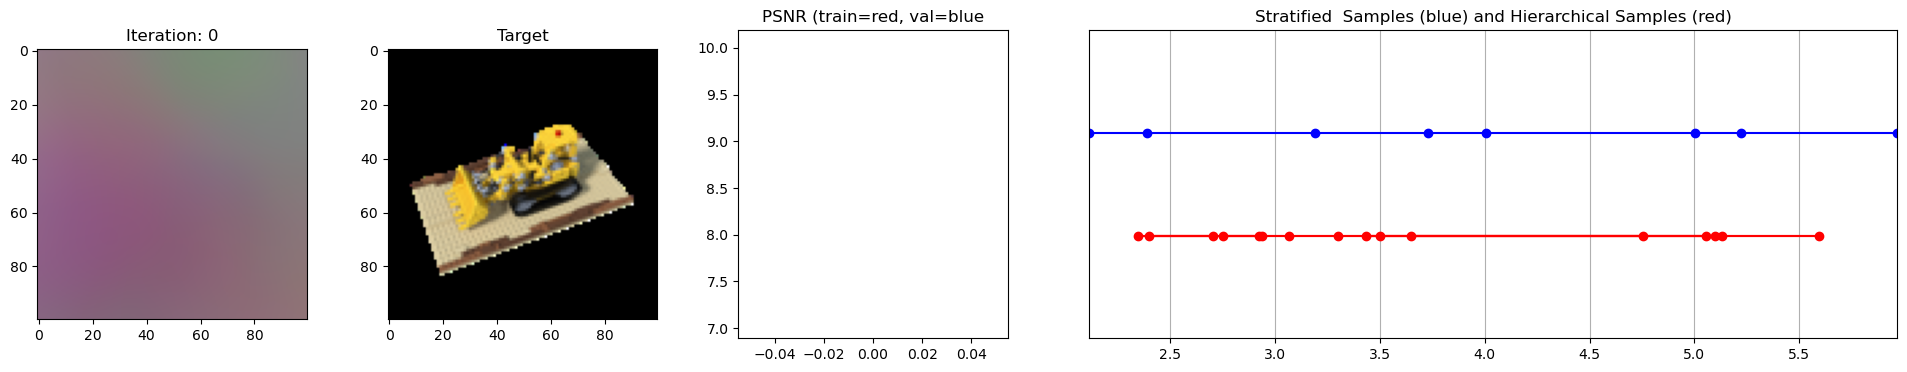

Val Loss:  0.20863647758960724  Val PSRN:  6.806097507476807


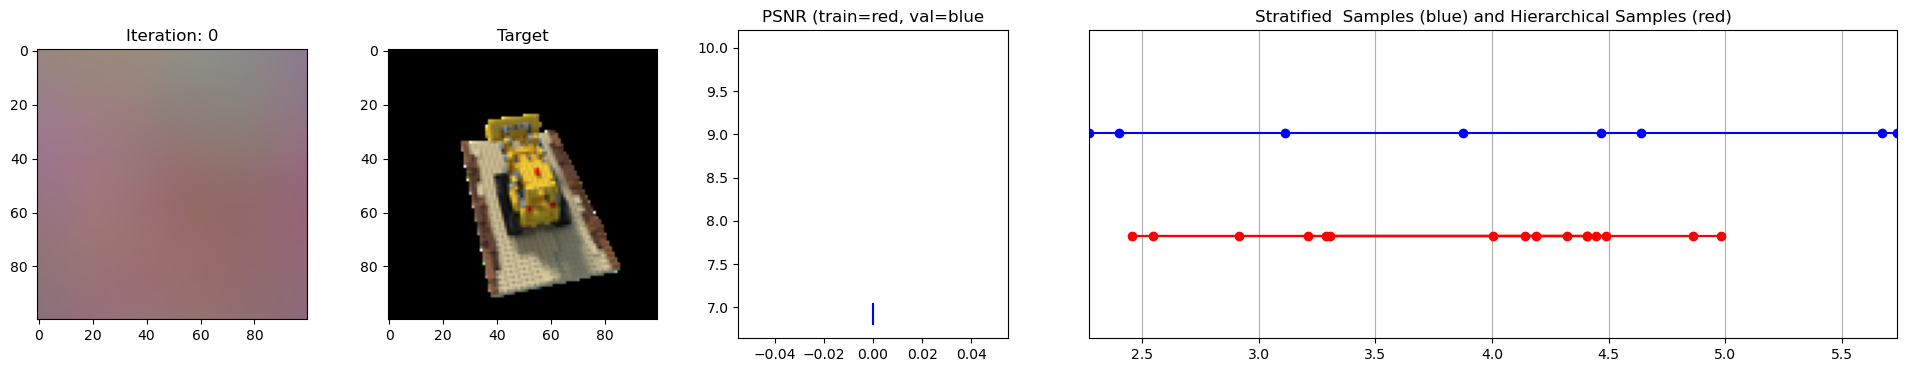

Val Loss:  0.1518009603023529  Val PSRN:  8.187254905700684


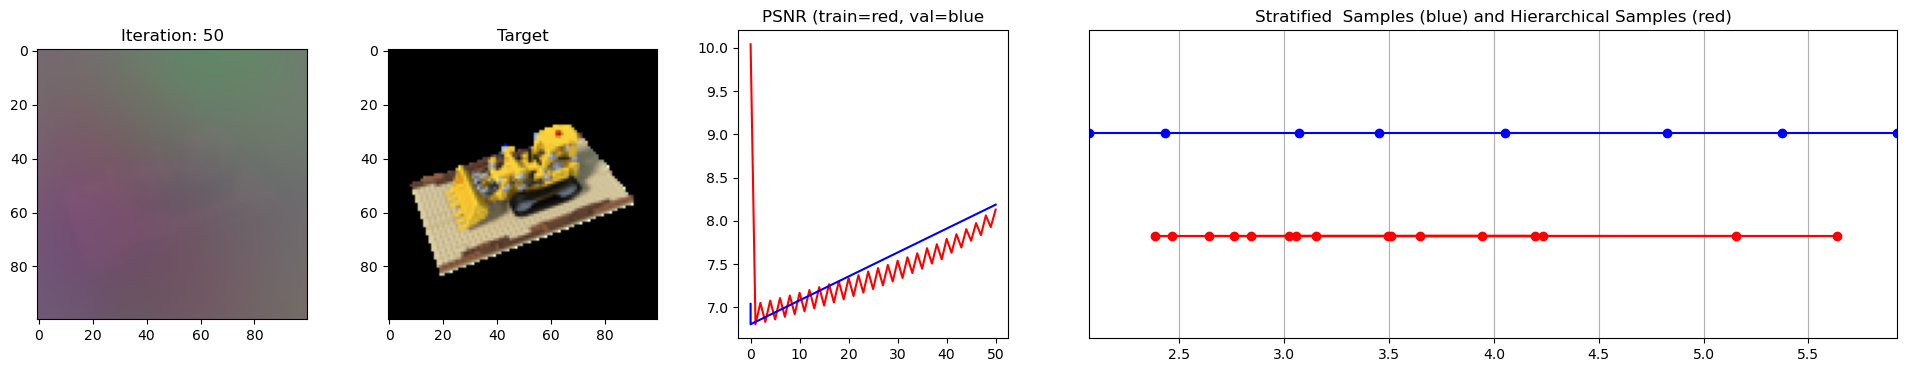

Val Loss:  0.15832440555095673  Val PSRN:  8.004521369934082


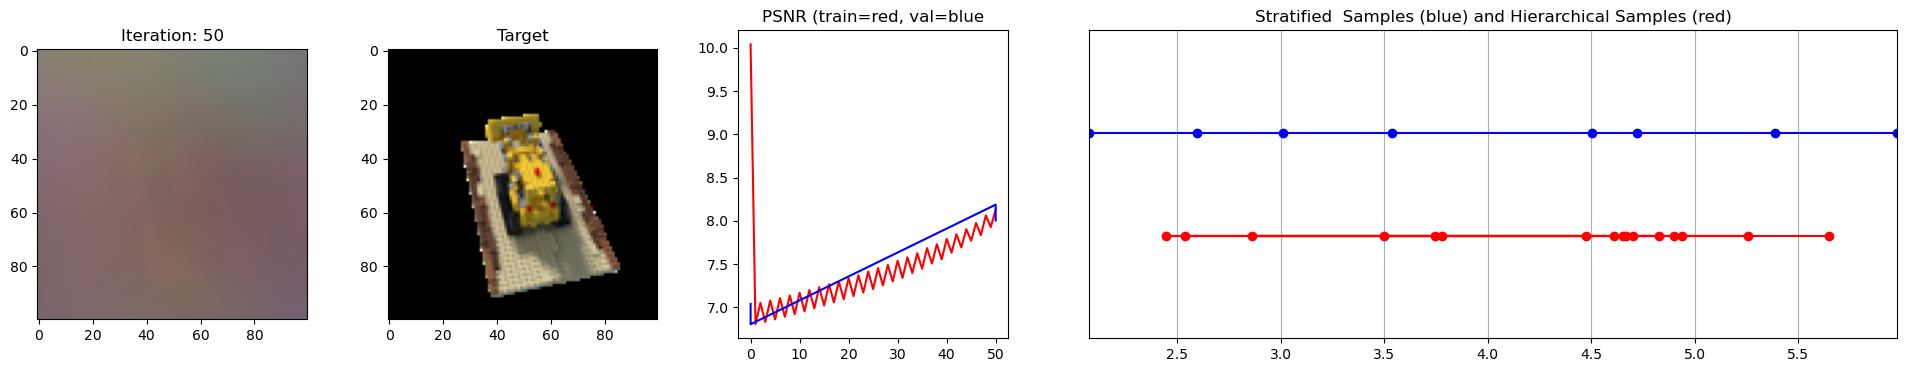

Val Loss:  0.0484517365694046  Val PSRN:  13.146906852722168


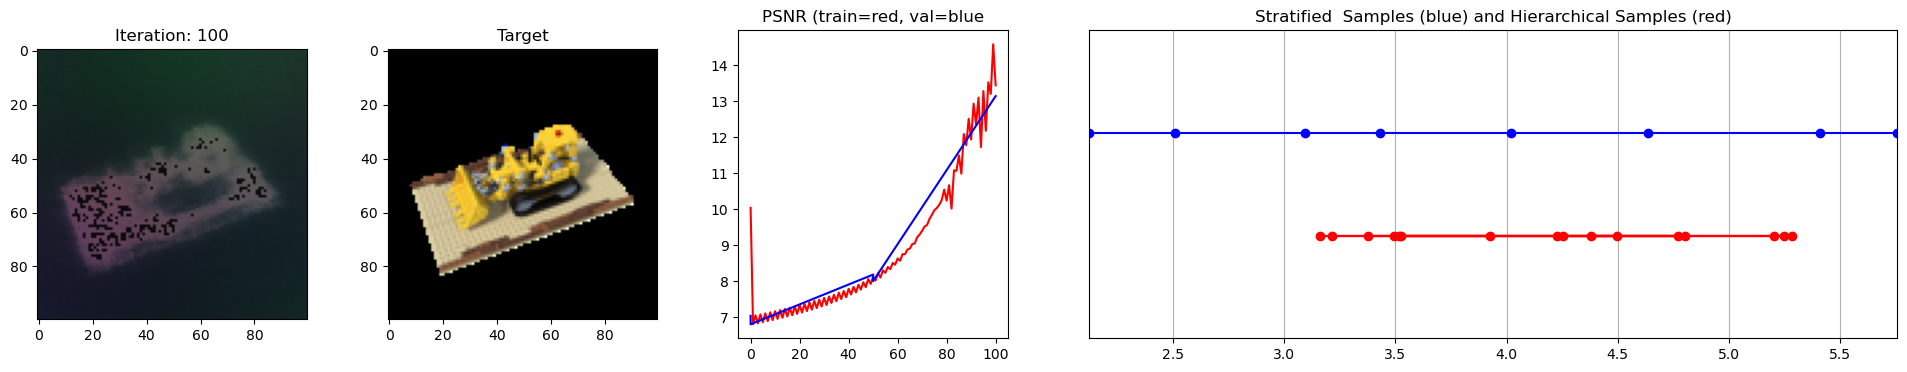

Val Loss:  0.03139135241508484  Val PSRN:  15.031900405883789


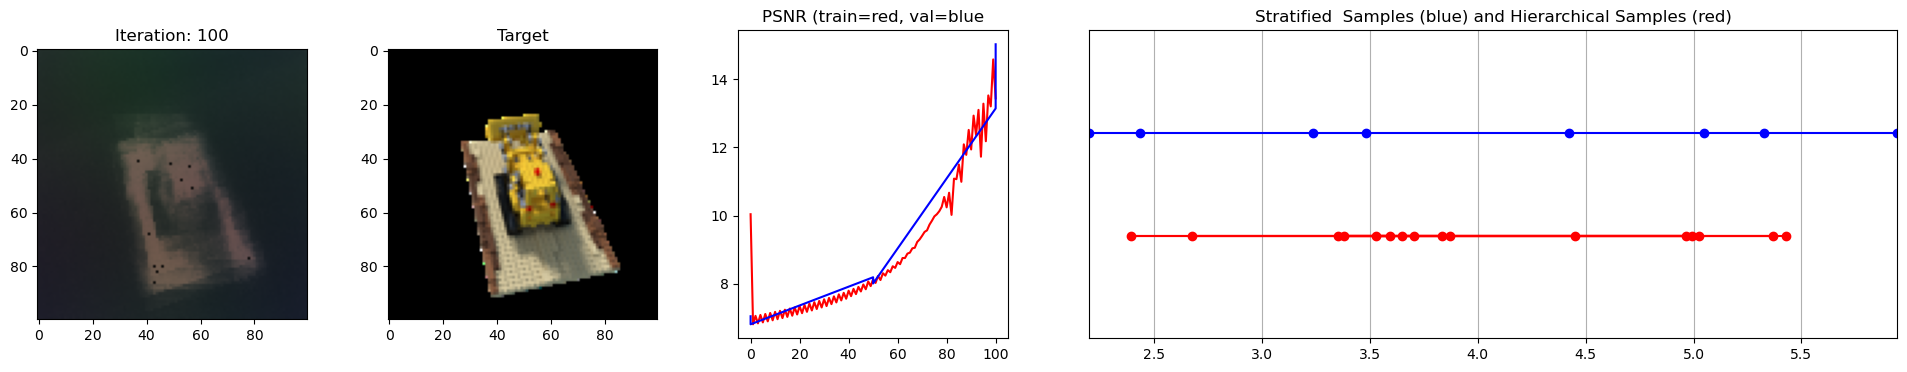

Val Loss:  0.01880079321563244  Val PSRN:  17.25823974609375


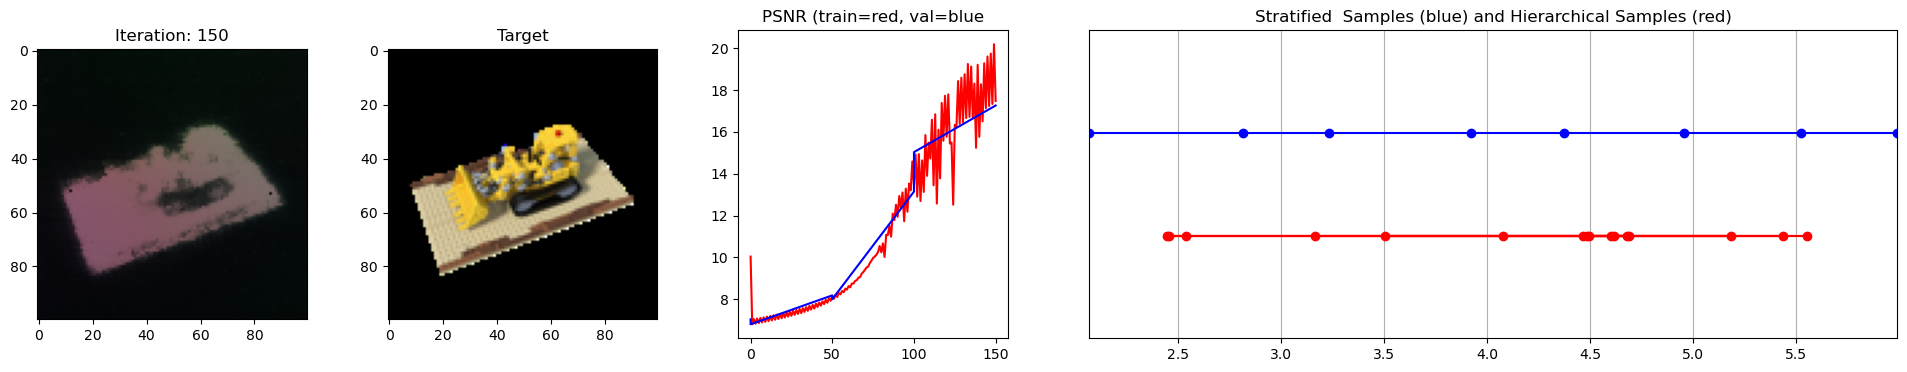

Val Loss:  0.010117432102560997  Val PSRN:  19.949298858642578


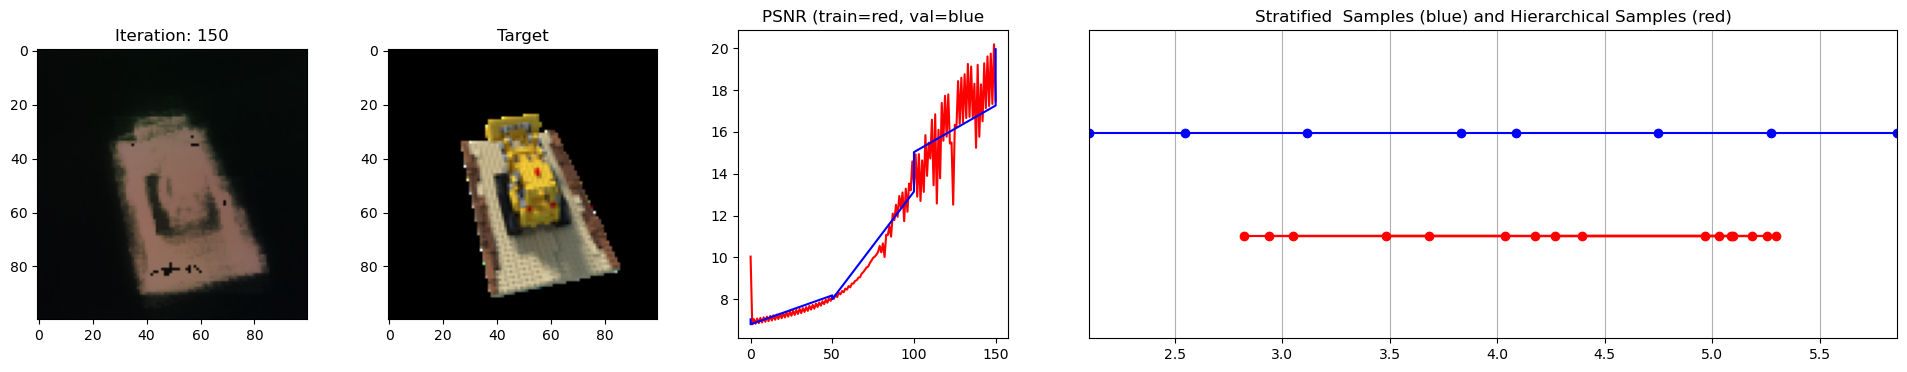

In [20]:
model.train()
train_psnrs = []
val_psnrs = []
iternums = []
train_psnrs = []
val_psnrs = []
iternums = []

lambda_reg = 1e-4
parameters = list(model.parameters()) + list(fine_model.parameters()) + list(encoder.parameters())
def regularization_loss(parameters):
    reg_loss = 0
    for param in parameters:
        reg_loss += torch.sum(param ** 2)
    return reg_loss

def check_gradients(model_name='', model=None):
    modellog.debug('*'*16)
    modellog.debug(model_name)
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            modellog.debug(f'{name} - Gradient mean: {param.grad.mean().item()}')
    modellog.debug('*'*16)

_S=0
pbar = tqdm(range(n_epochs), desc="Training Epochs")
# pbar = tqdm(range(1), desc="Training Epochs")
for i in pbar:
    debug('###')
    debug('### Train one time')
    debug('###')
    model.train()
    # One image per step

    # Randomly pick an image as the target.
    # Target Image
    target_img_idx = [testimg_idx, testimg_idx2][i%2]
    # target_img_idx = np.random.randint(images.shape[0])
    target_img = images[target_img_idx].to(device)
    # if center_crop and i < center_crop_iters:
    #     target_img = crop_center(target_img)
    height, width = target_img.shape[:2]
    target_img = target_img.reshape([-1, 3])
    # Pose
    target_pose = poses[target_img_idx].to(device)
    # Rays
    rays_o, rays_d = get_rays(height, width, focal, target_pose)
    rays_o = rays_o.reshape([-1, 3]).to(device)
    rays_d = rays_d.reshape([-1, 3]).to(device)
    # Handle Time
    timesteps = times[target_img_idx].reshape(1).to(device)
    datalog.debug(f'TIMESTEPS: {timesteps}')

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    outputs = nerf_forward(
        rays_o, rays_d, timesteps,
        near, far, encode, model,
        kwargs_sample_stratified=kwargs_sample_stratified,
        n_samples_hierarchical=n_samples_hierarchical,
        kwargs_sample_hierarchical=kwargs_sample_hierarchical,
        fine_model=fine_model,
        viewdirs_encoding_fn=encode_viewdirs,
        # time_encoding_fn=encode_time,
        chunksize=chunksize)

    # Check for any numerical issues.
    for k, v in outputs.items():
        if torch.isnan(v).any():
            print(f"! [Numerical Alert] {k} contains NaN.")
        if torch.isinf(v).any():
            print(f"! [Numerical Alert] {k} contains Inf.")

    # Backprop!
    rgb_predicted = outputs['rgb_map']

    loss = torch.nn.functional.mse_loss(
        rgb_predicted.to(device), target_img.to(device)) #+ lambda_reg * regularization_loss(parameters)
    loss.backward()

    # torch.nn.utils.clip_grad_norm_(parameters, max_norm=1.0)

    check_gradients(model_name='Model', model=model)
    check_gradients(model_name='Fine Model', model=fine_model)
    check_gradients(model_name='Encoder', model=encoder)

    optimizer.step()
    optimizer.zero_grad()
    # scheduler.step()

    psnr = -10. * torch.log10(loss)
    psnr = psnr.item()
    
    ###
    # Evaluation and logging

    epoch = i
    pbar.set_description(f"Epoch {epoch + 1}/{n_epochs}, PSNR: {psnr:.2f}, Loss: {loss.item():.5f}")

    train_psnrs.append(psnr)

    # Evaluate testimg at given display rate.
    if i % display_rate == 0:
        eval_one_time(i, iternums, train_psnrs, val_psnrs, model, encode, fine_model, encode_viewdirs,
                        testimgs=[testimg,testimg2], testposes=[testpose,testpose2], testtimes=[testtime,testtime2])
    
        eval_one_time(i, iternums, train_psnrs, val_psnrs, model, encode, fine_model, encode_viewdirs,
                        testimgs=[testimg2,testimg], testposes=[testpose2,testpose], testtimes=[testtime2,testtime])
        
        # save_training_progress(
        #     model,fine_model,encode,encode_viewdirs, encode_time, chunksize, 
        #     near, far, height, width, focal, epoch//display_rate, device
        # )


In [ ]:
_S

In [ ]:
debug('END'+'##'*64)